# Let's Train Tiny MoE





### Configure the machine and install packages


In [1]:
from typing import Literal

import os

#os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'

import jax

platform : Literal["darwin", "colab", "cuda", "tpu"] = "darwin"

try:
    import google.colab
    platform = "colab"
except ImportError:
    devices = jax.devices()
    if any(d.platform == "gpu" for d in devices):
        platform = "cuda"
    if any(d.platform == "tpu" for d in devices):
        platform = "tpu"

print(f"Running on {platform}")

if platform == "colab":
    !git clone https://github.com/novastar53/jaxpt
    !cd jaxpt && git checkout main && git pull
    !pip install tiktoken datasets --quiet
    !pip uninstall -y tensorflow

Running on cuda


In [2]:
from pathlib import Path
import sys

if platform == "colab":
    jaxpt_dir = str(Path().absolute() / "jaxpt" / "src" )
else:
    jaxpt_dir = str(Path().absolute().parent / "src" )


sys.path.append(jaxpt_dir)
print(jaxpt_dir)

/root/jaxpt/src


In [3]:
import os


import warnings

import jax
from jax.sharding import Mesh, PartitionSpec, NamedSharding
import flax
import jax.numpy as jnp
import numpy as np

# Hardware setup
print("JAX version:", jax.__version__)
print("Flax version", flax.__version__)

devices = jax.devices()
num_devices = len(devices)
print("Available devices:", num_devices)

requested_device = "gpu"

jax.config.update("jax_platform_name", requested_device) # Make sure we're using the GPU

device = jax.default_backend()
if device != requested_device:
    warnings.warn(f"not using {requested_device}. Using {device}")
else:
    print(f"using {device}")


#####################################
##        jax.lax matmul presets   ##
#####################################
## 'ANY_F8_ANY_F8_F32',
## 'ANY_F8_ANY_F8_F32_FAST_ACCUM'
## 'ANY_F8_ANY_F8_ANY'
## 'ANY_F8_ANY_F8_ANY_FAST_ACCUM'
## 'F16_F16_F16'
## 'F16_F16_F32'
## 'BF16_BF16_BF16'
## 'BF16_BF16_F32'
## 'BF16_BF16_F32_X3'
## 'BF16_BF16_F32_X6'
## 'TF32_TF32_F32'
## 'TF32_TF32_F32_X3'
## 'F32_F32_F32'
## 'F64_F64_F64'
#####################################

jax.config.update("jax_default_matmul_precision", "BF16_BF16_F32") # Set the default precision for matrix multiplication

#jax.config.update("jax_enable_x64", True) # Make sure the highest precision is enabled in case we need
#os.environ["NVIDIA_TF32_OVERRIDE"] = "1"
#os.environ["JAX_ENABLE_X64"] = "False"

if device == "tpu":
    def list_tpu_memory():
        devices = jax.devices()
        for device in devices:
            if 'TPU' in str(device.device_kind):
                print(f"Device: {device}, Memory: {device.memory_stats()['bytes_limit']/(1024*1024)},  Used: {device.memory_stats()['bytes_in_use']/(1024*1024)}")

    list_tpu_memory()

# Set up device mesh


mesh = jax.sharding.Mesh(jax.devices(), ["devices"])

# Test the device
A = jnp.array(np.random.normal(size=(4096, 4096)), dtype=jnp.float32) # Make sure matmul is fast
%timeit (A@A).block_until_ready()

JAX version: 0.7.0
Flax version 0.11.1
Available devices: 8
using gpu
861 μs ± 13.4 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Initialize the model and perform a sanity check

In [4]:
from datetime import datetime
import random
import string

from jaxpt.checkpointers import save_checkpoint, load_checkpoint, load_checkpoint_from_gcloud
from jaxpt.utils import generate_readable_code

if platform == "cuda":
  output_dir = Path("/workspace/alpha_training_runs") # Lambda Labs setup
else:
  output_dir = Path().absolute().parent  / "alpha_training_runs" # Local setup
print(f"Output dir: {output_dir}")

timestamp = datetime.now().strftime("%Y%m%d")
random_code = generate_readable_code()

run_dirname = f"run_{timestamp}_{random_code}"
print(f"Run: {run_dirname}")



Output dir: /workspace/alpha_training_runs
Run: run_20250820_elegancy_jarg


In [5]:
from flax import nnx

In [6]:
from jaxpt.infer import generate_completion_slow
from jaxpt.models import Tiny_MoE_Config, Tiny_MoE
from jaxpt.utils import count_params, create_sharded_model

import tiktoken
from transformers import AutoTokenizer

default = jax.random.key(1337)
gate_noise = jax.random.key(42)
rngs = nnx.Rngs(default=default, gate_noise=gate_noise)
#rngs = nnx.Rngs(0)

config = Tiny_MoE_Config(
                     name="Tiny_MoE_Panchatantra",
                     dtype=jnp.bfloat16, \
                     n_layer=4,
                     block_size=128,
                     n_head=9,
                     n_kv_head=3,
                     n_embed=576,
                     n_mlp_hidden=1536,
                     expert_weight_priority=False,
                     moe_bias=False,
                     sdpa_implementation="cudnn" if device=="gpu" else "xla")
nnx.display(config)

with mesh:
    m = create_sharded_model(Tiny_MoE, config, rngs)
    #m = load_checkpoint(Tiny_MoE, output_dir, config, "run_20250726_excudate_quilling", 2680, rngs)
    #m = load_checkpoint_from_gcloud(Tiny_MoE, config, output_dir, "alpha_training_runs", "run_20250725_yejxsn", "5390", rngs)
    #m = from_hf_pretrained(config, rngs)

    graphdef, rngstate, state = nnx.split(m, nnx.RngState, ...)
    total_params = count_params(m)
    moe_params = count_params(m, "moe")

    print(f"Parameter Count: {total_params:,}")
    print(f"MOE Parameter Count: {moe_params:,}")
    print(f"Replicated Parameter Count: {total_params - moe_params:,}")
    nnx.display(state)

    enc = tiktoken.get_encoding("gpt2")
    m.eval(add_noise=False, aux_loss=False)
    completions = generate_completion_slow(m, enc=enc, num_completions=8,
                                    max_length=21,
                                    prefix="Ducks quack, donkeys bray, cats mew, horses")
    for completion in completions:
        print(completion)

Parameter Count: 80,304,192
MOE Parameter Count: 42,476,544
Replicated Parameter Count: 37,827,648


Ducks quack, donkeys bray, cats mew, horses Tasman Tasman Tasman Tasman Tasman Tasman
Ducks quack, donkeys bray, cats mew, horses Tasman Tasman Tasman Tasman Tasman Tasman
Ducks quack, donkeys bray, cats mew, horsesassisassisassisassisassisassis
Ducks quack, donkeys bray, cats mew, horses Tasman Tasman Tasman Tasman Tasman Tasman
Ducks quack, donkeys bray, cats mew, horses Tasman Tasman Tasman Tasman Tasman Tasman
Ducks quack, donkeys bray, cats mew, horsesSHASHASHASHASHASHA
Ducks quack, donkeys bray, cats mew, horses Tasman Tasman Tasman Tasman Tasman Tasman
Ducks quack, donkeys bray, cats mew, horses Tasman Tasman Tasman Tasman Tasman Tasman


### Configure Training Run

In [7]:
import orbax.checkpoint as ocp

# Set up save and load optimizer

def save_optimizer_state(optimizer):
  state_dirpath = (
    output_dir / optimizer.model.config.name / "optimizer_checkpoints" / run_dirname
  )
  state_dirpath.mkdir(parents=True, exist_ok=True)
  _, state = nnx.split(optimizer)
  state.model = None
  cp = ocp.StandardCheckpointer()
  print(f"Saving optimizer state to {state_dirpath}/step-{optimizer.step.value.item()}")
  cp.save(state_dirpath / f"step-{optimizer.step.value.item()}", state)
  cp.wait_until_finished()

def load_optimizer_state(model, optimizer, run_dirname, step):
  cp = ocp.StandardCheckpointer()
  graphdef, state = nnx.split(optimizer)
  state_model = state.model
  state.model = None
  state = cp.restore(output_dir / optimizer.model.config.name / "optimizer_checkpoints" / run_dirname / f"step-{step}", target=state)
  state.model = state_model
  optimizer = nnx.merge(graphdef, state)
  return optimizer


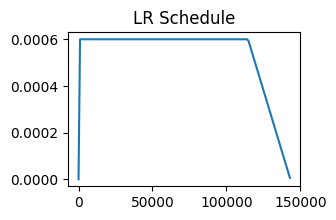

weight decay param count: 80,299,008
tokens/batch: 16,384
block size: 128
batch size: 128
no. gradient accumulation steps: 1
effective batch size: 128
effective batch size per device:  16
max steps: 143,335


In [10]:
import dataclasses

import optax

############################
# Nvidia A100 (x 8) Config
############################

@dataclasses.dataclass
class TrainerConfig:
  num_tokens_per_batch: int = 2**14 # 2**19, 0.5 million as per the GPT 3.5 paper
  mB: int = 16 * num_devices
  T: int = 128
  max_steps: int = int((146776*2000) // (2**11))
  max_lr: float = 6e-4
  min_lr: float = max_lr * 0.1
  max_grad_norm: float = 1.0  # Clip gradients to this norm
  warmup_steps: int = 775
  print_interval: int = 10
  eval_interval: int = 10000
  checkpoint_interval: int = 5000
  grad_accumulation_steps: int = num_tokens_per_batch // (mB * T) # Number of steps over which to average the gradient


##############
# CPU Config #
##############

trconf = TrainerConfig()
'''
trconf = TrainerConfig(
  num_tokens_per_batch=2**9,
  mB=2**4,
  T=2**5,
  max_steps=9*48, # 6 epoch(s)
  max_lr=6e-4,
  min_lr=6e-5,
  max_grad_norm=1.0,
  warmup_steps=10,
  print_interval=1,
  eval_interval=50,
  checkpoint_interval=0,

)

trconf.grad_accumulation_steps =  trconf.num_tokens_per_batch // (trconf.mB * trconf.T * num_devices) # Number of steps over which to average the gradient
'''

# Set up the optimizer
def trapezoidal_schedule(step):

    warmup_lr = trconf.max_lr * (step + 1) / trconf.warmup_steps
    cooldown_lr = trconf.max_lr * (trconf.max_steps - step) / (trconf.max_steps - 0.8 * trconf.max_steps)

    return jnp.where(step < trconf.warmup_steps,
                     warmup_lr,
                     jnp.where(step < 0.8 * trconf.max_steps, trconf.max_lr, cooldown_lr))

steps = range(0, trconf.max_steps, 1000)
total_schedule = [ trapezoidal_schedule(step) for step in steps ]
import matplotlib.pyplot as plt
plt.figure(figsize=(3,2))
plt.plot(steps, total_schedule)
plt.title("LR Schedule")
plt.show()

# Generate a weight decay mask
# First split the model into params and variables
graphdef, params, variables = nnx.split(m, nnx.Param, nnx.Variable)
# Then create a mask for the weight decay params
weight_decay_mask = jax.tree_util.tree_map(lambda x: len(x.shape) > 1, params)

tx = optax.chain(
    #optax.clip_by_global_norm(trconf.max_grad_norm),
    optax.adamw(trapezoidal_schedule, b1=0.9, b2=0.95, weight_decay=0.1, mask=weight_decay_mask),
    #optax.adafactor(trapezoidal_schedule, weight_decay_rate=0.1, weight_decay_mask=weight_decay_mask)
    #optax.adam(trapezoidal_schedule)
)
optimizer = nnx.Optimizer(m, tx, wrt=nnx.Param)

#optimizer = load_optimizer_state(m, optimizer, "run_20250726_excudate_quilling", 2680)


# count the number of weight decay params
def f(x, y):
    if x:
        return y.size
    return 0

weight_decay_params = jax.tree_util.tree_map(f, weight_decay_mask, params)
weight_decay_param_count = jax.tree_util.tree_reduce(lambda x, y: x + y, weight_decay_params, 0)


print(f"weight decay param count: {weight_decay_param_count:,}")

print(f"tokens/batch: {trconf.num_tokens_per_batch:,}")
print(f"block size: {trconf.T}")
print(f"batch size: {trconf.mB}")
print(f"no. gradient accumulation steps: {trconf.grad_accumulation_steps}")
print(f"effective batch size: {trconf.grad_accumulation_steps * trconf.mB}")
print(f"effective batch size per device: ", trconf.grad_accumulation_steps * trconf.mB // num_devices)
print(f"max steps: {trconf.max_steps:,}")


### DataLoader and Validation Setup



In [11]:
import os

from jaxpt.dataloaders import DataLoader, HuggingfaceDataLoader, CloudDataLoader

'''
train_dl = HuggingfaceDataLoader(batch_size=trconf.mB,
                                 block_size=trconf.T,
                                 device_rank=1,
                                 tokenizer="HuggingFaceTB/SmolLM-135M",
                                 dataset_paths=["HuggingFaceTB/smollm-corpus",
                                                "HuggingFaceTB/smollm-corpus",
                                                "HuggingFaceTB/smollm-corpus"],
                                 dataset_names=["cosmopedia-v2",
                                                "python-edu",
                                                "fineweb-edu-dedup"],
                                 probabilities=[0.111, 0.016 , 0.873],
                                 label="train",
                                 random_seed=1337,
                                 buffer_size=10_000,
                                 streaming=True)
'''

#os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../alpha-448101-282bc1b884cd.json"

#train_dl = CloudDataLoader(bucket_name="jaxpt_datasets",
#                      bucket_prefix="fineweb-edu-100b/processed",
#                      batch_size=trconf.mB,
#                      block_size=trconf.T,
#                      device_rank=1,
#                      label="train")

train_dl = DataLoader(dirpath="../datasets/panchatantra-ryder/processed",
                      batch_size=trconf.mB,
                      block_size=trconf.T,
                      device_rank=1,
                      label="train")



DataLoader initialized:
------------------------
label:          train
shards:         1
shard size:     111,790
batch size:     128
block size:     128
device rank:    1
start shard:    0
start pos:      0
------------------------


In [12]:
from jaxpt.utils import append_to_csv

# Create log dir
log_dir = output_dir / m.config.name / "logs"
log_dir.mkdir(parents=True, exist_ok=True)
print(f"Log directory: {log_dir}")

train_losses = []
append_to_csv(log_dir / f"{run_dirname}_train.csv", ["step", "lr", "loss", "time", "tokens_processed", "tokens_per_sec"])
print(f"Starting from step: {optimizer.step.value.item()}")

Log directory: /workspace/alpha_training_runs/Tiny_MoE_Panchatantra/logs
Starting from step: 0


In [14]:
%matplotlib inline

import time

import matplotlib.pyplot as plt

from jaxpt.train import moe_loss_fn, loss_fn

def moe_loss_fn(model, batch, targets):
    logits, aux_loss = model(batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, targets)
    loss = loss.mean() + model.config.aux_loss_coeff * aux_loss
    return loss, aux_loss


@nnx.jit
def train_step(model, optimizer, batch, target):
    batch = batch.squeeze()
    target = target.squeeze()
    (loss, aux_loss), grads = nnx.value_and_grad(moe_loss_fn, has_aux=True)(model, batch, target)
    optimizer.update(model, grads)
    return loss, aux_loss


with mesh:
  data_sharding = NamedSharding(mesh, PartitionSpec("devices",))
  m.train(add_noise=True, aux_loss=True)
  try:
    while optimizer.step.value.item() < trconf.max_steps:
      step = optimizer.step.value.item()
      start = time.time()
      batch, target = train_dl()
      batch = jax.device_put(batch.squeeze(), data_sharding)
      target = jax.device_put(target.squeeze(), data_sharding)
      avg_loss, aux_loss = train_step(m, optimizer, batch, target)
      #print(target[0, :])
      #print(jnp.argmax(logits, axis=-1)[0, :])
      #break
      avg_loss.block_until_ready()
      iter_time = time.time() - start
      if step % trconf.print_interval == 0:
        avg_loss = avg_loss.item()
        lr = trapezoidal_schedule(step)
        sub_step_time = iter_time / trconf.grad_accumulation_steps
        tokens_per_sec = trconf.mB * trconf.T * trconf.grad_accumulation_steps / iter_time
        tokens_processed = (step+1) * trconf.grad_accumulation_steps * trconf.mB * trconf.T

        train_losses.append((step, avg_loss))
        append_to_csv(log_dir / f"{run_dirname}_train.csv", [step, lr, avg_loss, iter_time*1000, tokens_processed, tokens_per_sec])
        print(f"{step} | lr: {lr:0.4f} | "
              f"loss: {avg_loss:0.4f} | "
              f"aux_loss: {aux_loss:0.4f} | "
              f"time: {iter_time*1000:0.2f}ms | "
              f"tokens processed: {tokens_processed:,} | "
              f"tok/sec: {tokens_per_sec:,.2f}", end="\n")
      if step > 0 and step % trconf.eval_interval == 0:
        print("Evaluation TBD")
      if step > 0 and step % trconf.checkpoint_interval == 0:
        print(f"Saving checkpoint at step {step}")
        save_checkpoint(m, output_dir, run_dirname, step)
        save_optimizer_state(optimizer)
  except KeyboardInterrupt:
      print("Received KeyboardInterrupt. Exiting...")

  plt.figure(figsize=(5, 3))
  plt.plot([x[0] for x in train_losses], [x[1] for x in train_losses], label="train loss")
  plt.legend()
  plt.savefig(log_dir / f"{run_dirname}.png", dpi=300, bbox_inches="tight", transparent=True)
  plt.show()


ValueError: Custom node type mismatch: expected type: <class 'flax.nnx.variablelib.Param'>, value: JitTracer<float32[50304,576]>.

In [12]:
save_checkpoint(m, output_dir, run_dirname, optimizer.step.value.item())
save_optimizer_state(optimizer)

Saving optimizer state to /workspace/alpha_training_runs/Tiny_MoE_Panchatantra/optimizer_checkpoints/run_20250726_excudate_quilling/step-2680


In [12]:
from functools import partial
from jaxpt.infer import generate_completion_slow


with mesh:
    m.eval(add_noise=False, aux_loss=False)
    enc = tiktoken.get_encoding("gpt2")
    completions = generate_completion_slow(m, enc=enc, num_completions=8,
                                    max_length=25,
                                    temperature=0.0001,
                                    key=jax.random.key(0),
                                    prefix=", not foolish friends, 'Tis wiser far to cling")
                                    #prefix=" enraged; A crowd's a fearsome thing: The ants devoured the giant")
    for completion in completions:
        print(completion)

, not foolish friends, 'Tis wiser far to cling Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins
, not foolish friends, 'Tis wiser far to cling Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins
, not foolish friends, 'Tis wiser far to cling Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins
, not foolish friends, 'Tis wiser far to cling Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins
, not foolish friends, 'Tis wiser far to cling Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins
, not foolish friends, 'Tis wiser far to cling Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins Penguins
, not foolish fr